# CS412 Machine Learning – Spring 2025 Final Project

**Title:** Sentiment Analysis Using Logistic Regression + TF-IDF  



## 1. Introduction

This project focuses on performing binary sentiment analysis using the IMDB dataset. We aim to classify movie reviews as **positive** or **negative** using machine learning methods. Our primary model here is **Logistic Regression** trained on **TF-IDF features**. This notebook demonstrates the full pipeline from preprocessing to evaluation.


## 2. Problem Description

The task is a **binary classification** problem. Each movie review in the dataset is labeled as either `positive` or `negative`. Our goal is to predict the correct sentiment label for each review using machine learning models.


## 3. Dataset

We use the **IMDB Movie Reviews Dataset**, consisting of 50,000 labeled reviews:  
- 25,000 positive reviews  
- 25,000 negative reviews  

Each record has two fields:  
- `review` – the actual movie review  
- `sentiment` – the label (positive or negative)  


### 4.1 Import Required Libraries

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


### 4.2 Load Dataset

In [ ]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 5. Dataset Statistics

In [ ]:
print("Shape:", df.shape)
print("\nClass Distribution:")
print(df['sentiment'].value_counts())

df['review_length'] = df['review'].apply(lambda x: len(x.split()))
print("\nReview Length (words):")
print("Average:", df['review_length'].mean())
print("Max:", df['review_length'].max())
print("Min:", df['review_length'].min())


Shape: (50000, 2)

Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Review Length (words):
Average: 231.15694
Max: 2470
Min: 4


## 6. Preprocessing

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

### 6.1 Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    df['clean_review'], df['label'],
    test_size=0.10,
    stratify=df['label'],
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1111,
    stratify=y_temp,
    random_state=42
)

print(f"Train: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Val:   {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test:  {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")


Train: 40000 (80.0%)
Val:   5000 (10.0%)
Test:  5000 (10.0%)


## 7. Feature Extraction with TF-IDF

In [ ]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.8,
    min_df=5,
    max_features=20000,
    stop_words='english'
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf   = tfidf.transform(X_val)


## 8. Model Training – Logistic Regression

In [ ]:
model = LogisticRegression(C=2.0, max_iter=200, solver='liblinear')
history = model.fit(X_train_tfidf, y_train)
model.fit(X_train_tfidf, y_train)



LogisticRegression(C=2.0, max_iter=200, solver='liblinear')

## 9. Evaluation Results

In [ ]:
val_pred = model.predict(X_val_tfidf)
print("Validation accuracy:", accuracy_score(y_val, val_pred))
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Validation accuracy: 0.8974
Accuracy: 0.9008
Macro F1 Score: 0.9007942698770282

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      2500
           1       0.89      0.91      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000


Confusion Matrix:
 [[2233  267]
 [ 229 2271]]


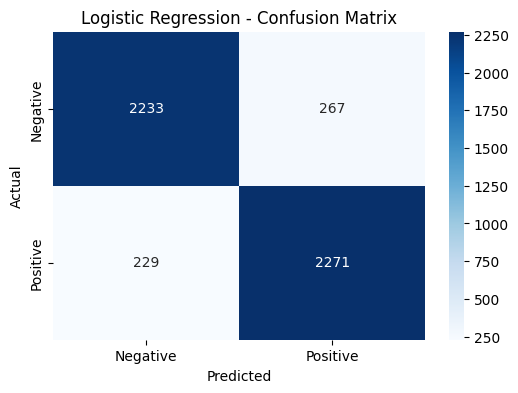

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

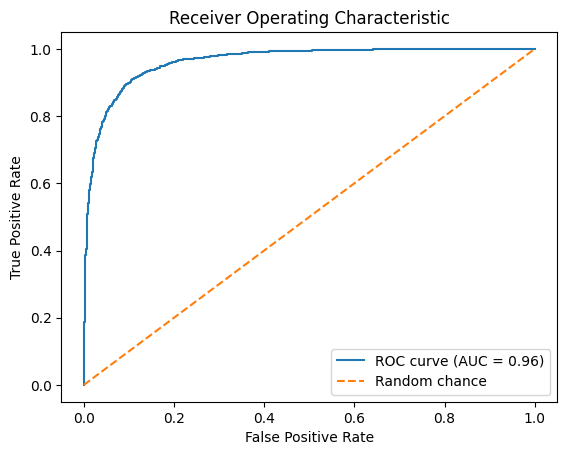

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_proba = model.predict_proba(X_test_tfidf)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
